# Spam Detection NLP Project

## Setup

#### Import Libraries

In [1]:
import pandas as pd
import numpy as np
import nltk
import re
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, GlobalAveragePooling1D, Dense
from tensorflow.keras.optimizers import Adam

from collections import Counter

nltk.download('stopwords')
from nltk.corpus import stopwords

from utils.preprocessing import clean_text
from utils.eda import plot_message_lengths, plot_top_words_by_class, plot_venn_words
from utils.baseline import run_baseline_model
from utils.bert import run_bert_model
from utils.csv import write_stats_to_csv


2025-05-17 17:47:42.094282: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-05-17 17:47:42.101874: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747525662.109255   20322 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747525662.111706   20322 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1747525662.117921   20322 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

In [2]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

#### Load Dataset


In [3]:
url = "https://raw.githubusercontent.com/justmarkham/pycon-2016-tutorial/master/data/sms.tsv"
df = pd.read_csv(url, sep='\t', names=["label", "message"])

df.head()
df.describe()

,label,message
count,5572,5572
unique,2,5169
top,ham,"Sorry, I'll call later"
freq,4825,30


## Pre-Processing

#### Remove Stop-Words

In [4]:
VARIANTS = ['raw', 'stop', 'stop_lemma', 'stop_stem']
df['raw'] = df['message'].apply(lambda x: clean_text(x, 'raw'))
df['stop'] = df['message'].apply(lambda x: clean_text(x, 'stop'))
df['stop_lemma'] = df['message'].apply(lambda x: clean_text(x, 'stop_lemma'))
df['stop_stem'] = df['message'].apply(lambda x: clean_text(x, 'stop_stem'))


# Print examples where all variants are different
print("\nExamples where all variants are different:")
different_variants = []

for idx, row in df.iterrows():
    variants = [row[variant] for variant in VARIANTS]
    # Check if all variants are different from each other
    if len(set(variants)) == len(VARIANTS):
        different_variants.append({
            'message': row['message'],
            'raw': row['raw'],
            'stop': row['stop'],
            'stop_lemma': row['stop_lemma'],
            'stop_stem': row['stop_stem'],
            'label': row['label']
        })
        # Limit to 5 examples to avoid overwhelming output
        if len(different_variants) >= 5:
            break

# Display the examples in a formatted way
for i, example in enumerate(different_variants, 1):
    print(f"\nExample {i} ({example['label']}):")
    print(f"Original: {example['message']}")
    print(f"Raw:      {example['raw']}")
    print(f"Stop:     {example['stop']}")
    print(f"Lemma:    {example['stop_lemma']}")
    print(f"Stem:     {example['stop_stem']}")



Examples where all variants are different:

Example 1 (ham):
Original: Nah I don't think he goes to usf, he lives around here though
Raw:      nah i dont think he goes to usf he lives around here though
Stop:     nah dont think goes usf lives around though
Lemma:    nah dont think go usf life around though
Stem:     nah dont think goe usf live around though

Example 2 (spam):
Original: FreeMsg Hey there darling it's been 3 week's now and no word back! I'd like some fun you up for it still? Tb ok! XxX std chgs to send, £1.50 to rcv
Raw:      freemsg hey there darling its been 3 weeks now and no word back id like some fun you up for it still tb ok xxx std chgs to send 150 to rcv
Stop:     freemsg hey darling 3 weeks word back id like fun still tb ok xxx std chgs send 150 rcv
Lemma:    freemsg hey darling 3 week word back id like fun still tb ok xxx std chgs send 150 rcv
Stem:     freemsg hey darl 3 week word back id like fun still tb ok xxx std chg send 150 rcv

Example 3 (ham):
Origina

## EDA

Saved plot to data/eda/raw/message_lengths.png
Saved plot to data/eda/raw/top_spam.png
Saved plot to data/eda/raw/top_spam.png
Saved plot to data/eda/raw/top_ham.png
Saved plot to data/eda/raw/top_ham.png
Saved plot to data/eda/raw/venn.png
Saved plot to data/eda/stop/message_lengths.png
Saved plot to data/eda/stop/top_spam.png
Saved plot to data/eda/stop/top_spam.png
Saved plot to data/eda/stop/top_ham.png
Saved plot to data/eda/stop/top_ham.png
Saved plot to data/eda/stop/venn.png
Saved plot to data/eda/stop_lemma/message_lengths.png
Saved plot to data/eda/stop_lemma/top_spam.png
Saved plot to data/eda/stop_lemma/top_spam.png
Saved plot to data/eda/stop_lemma/top_ham.png
Saved plot to data/eda/stop_lemma/top_ham.png
Saved plot to data/eda/stop_lemma/venn.png
Saved plot to data/eda/stop_stem/message_lengths.png
Saved plot to data/eda/stop_stem/top_spam.png
Saved plot to data/eda/stop_stem/top_spam.png
Saved plot to data/eda/stop_stem/top_ham.png
Saved plot to data/eda/stop_stem/top_ha

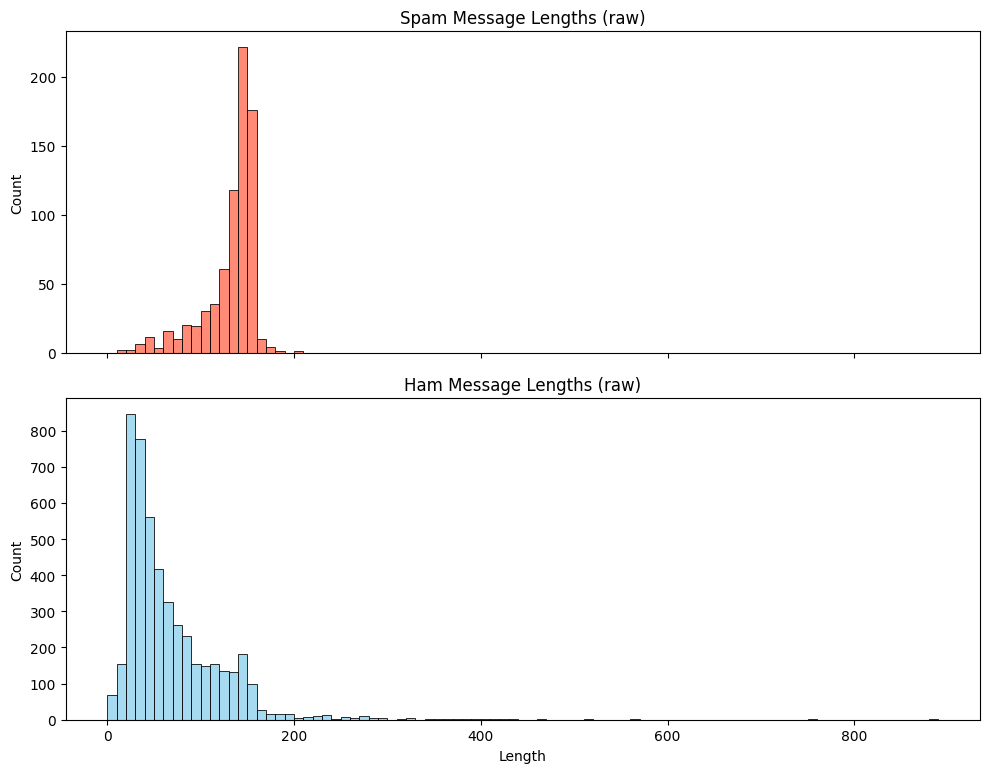

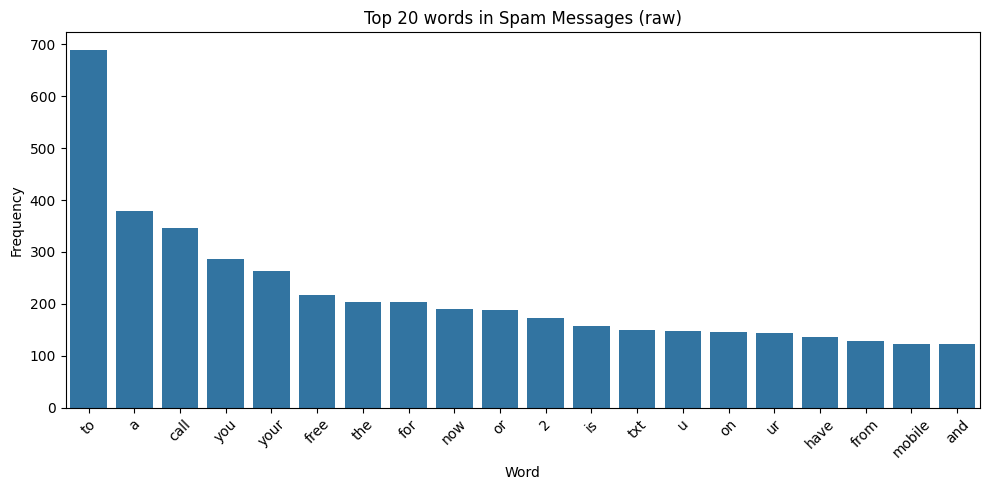

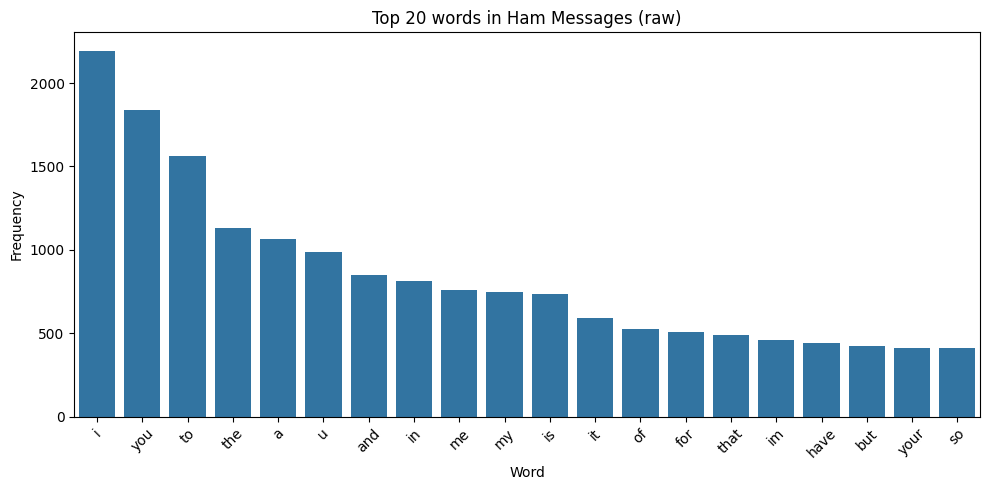

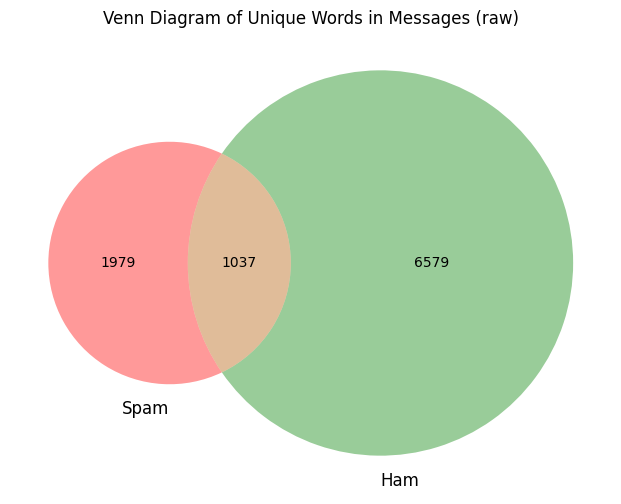

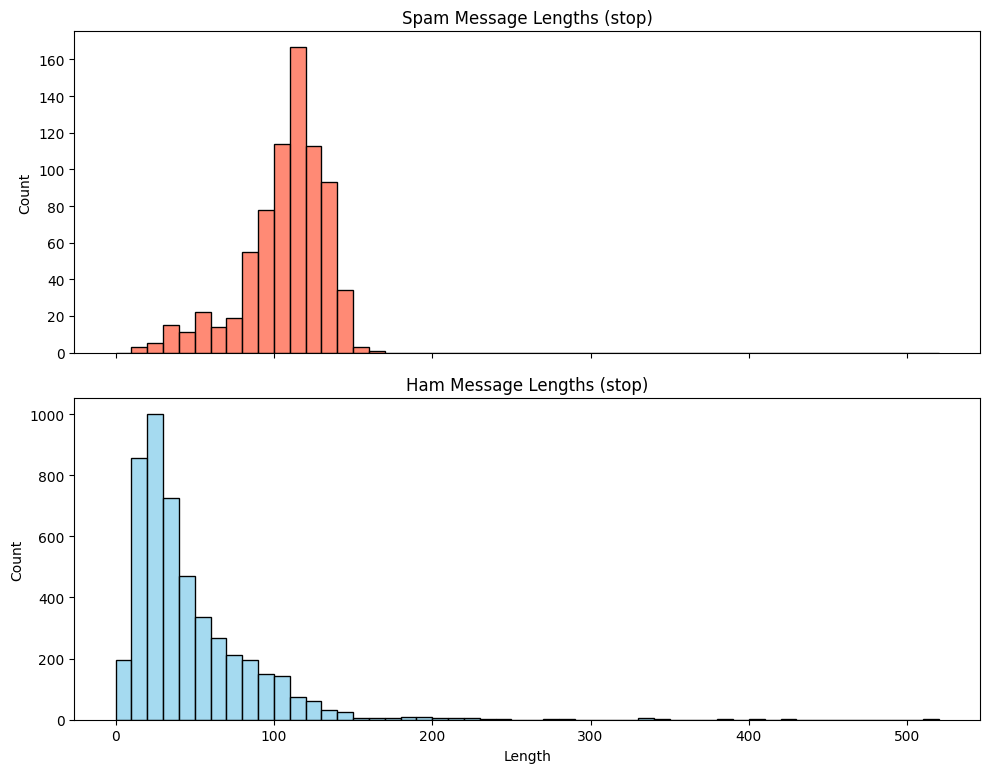

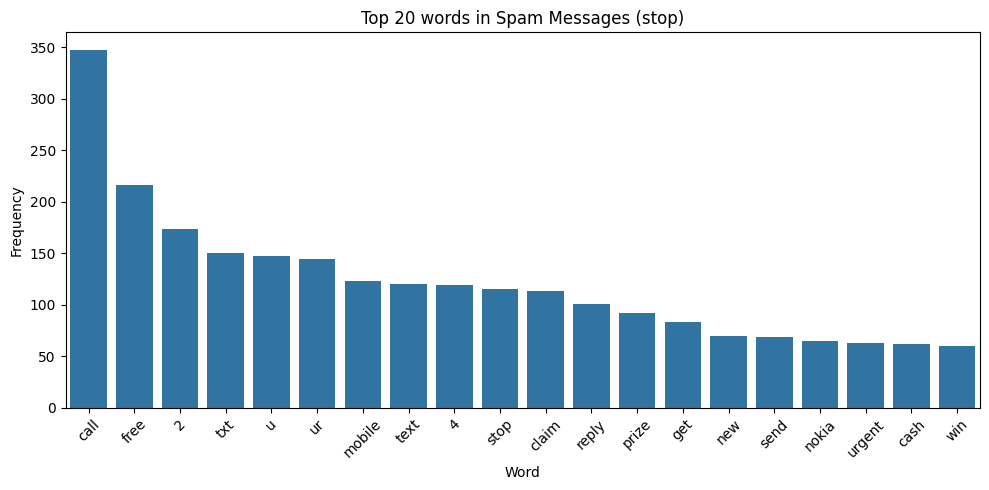

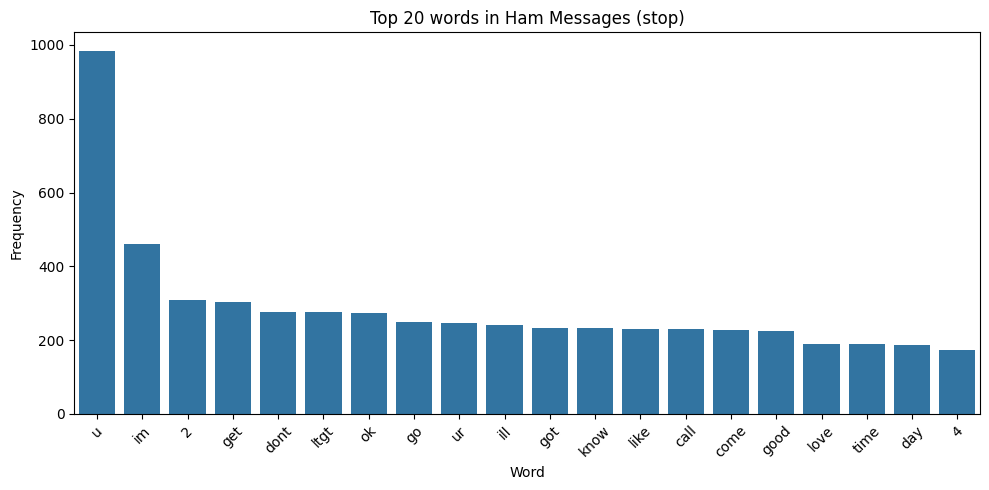

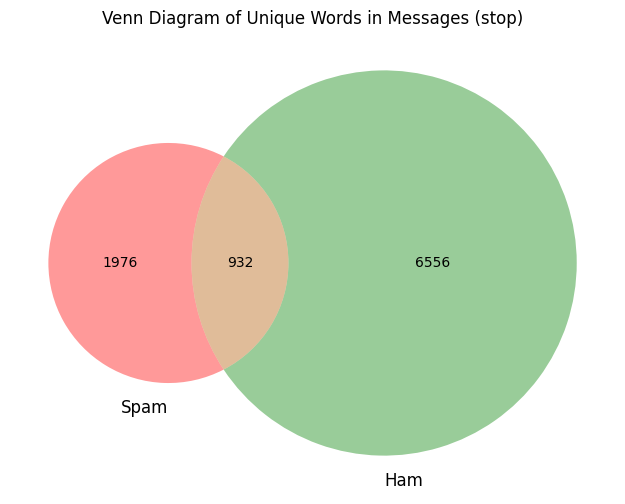

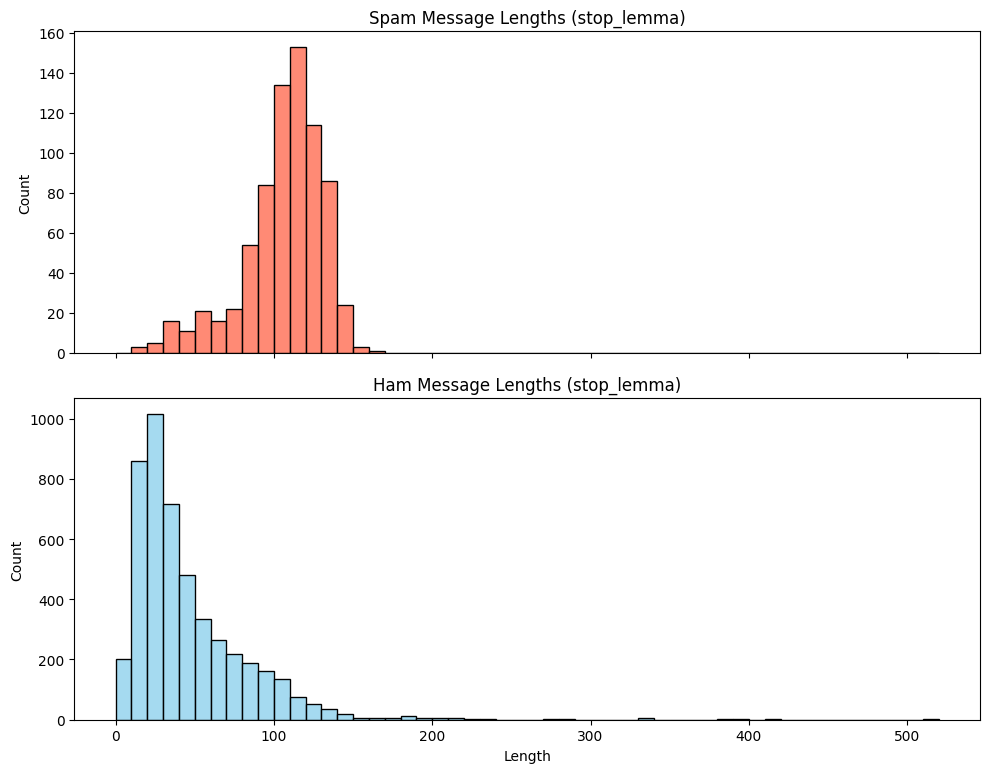

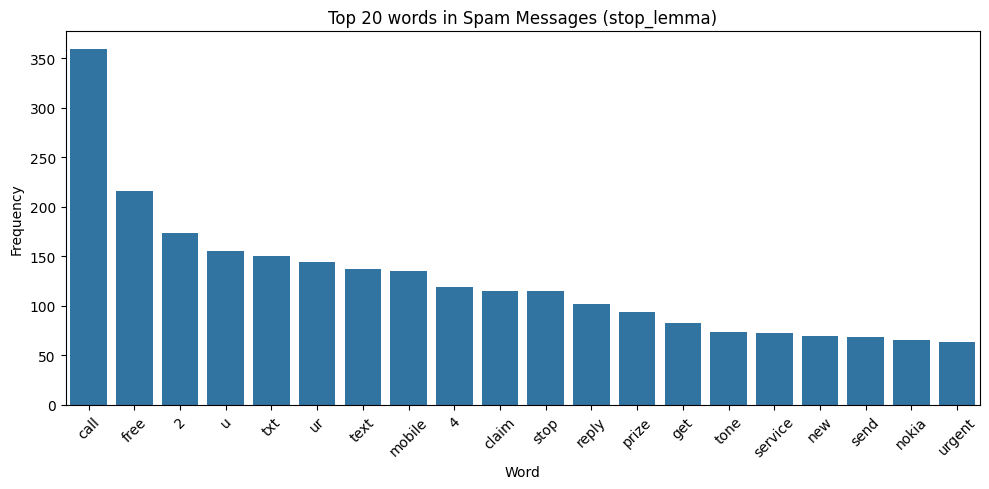

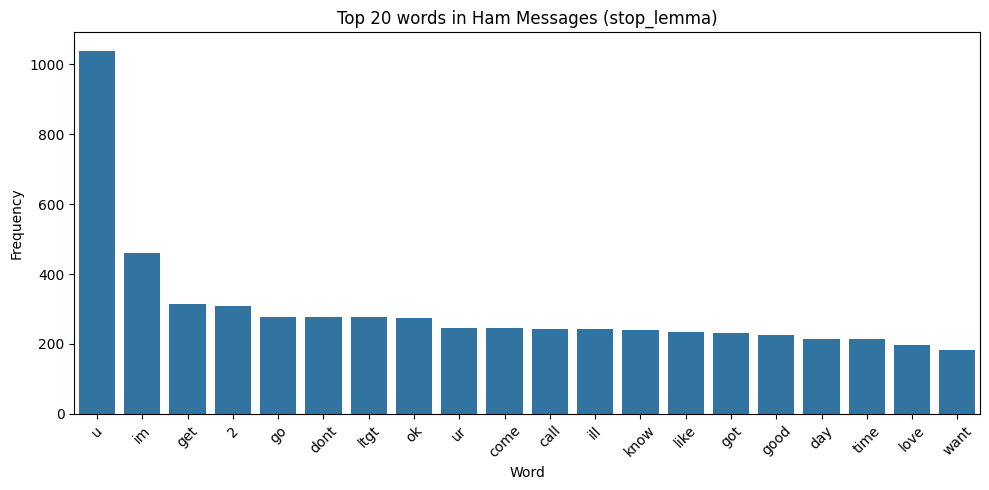

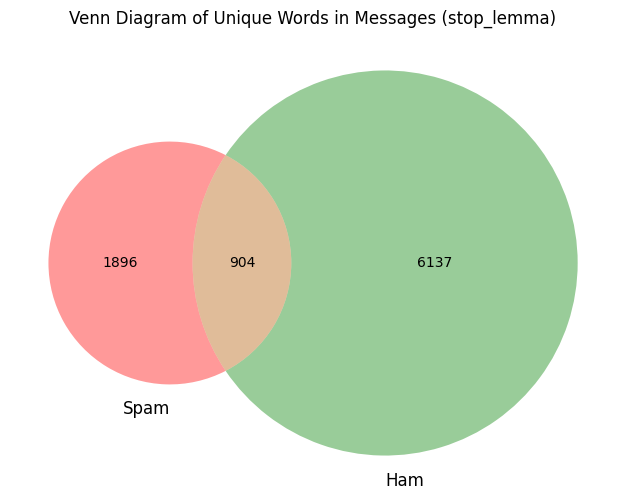

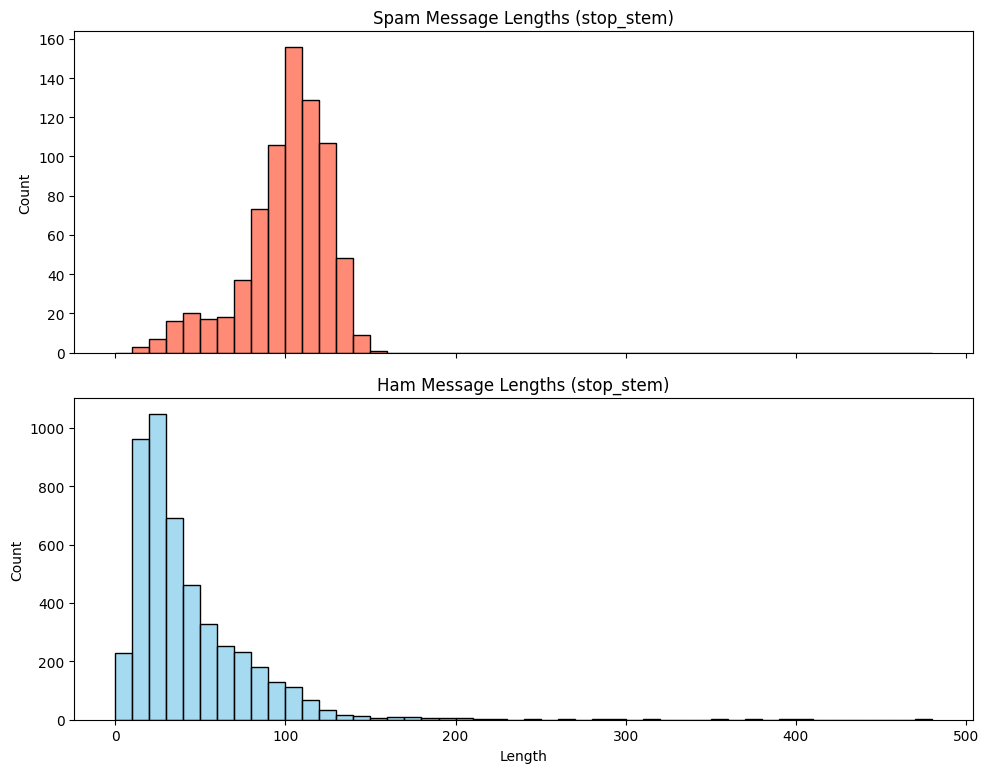

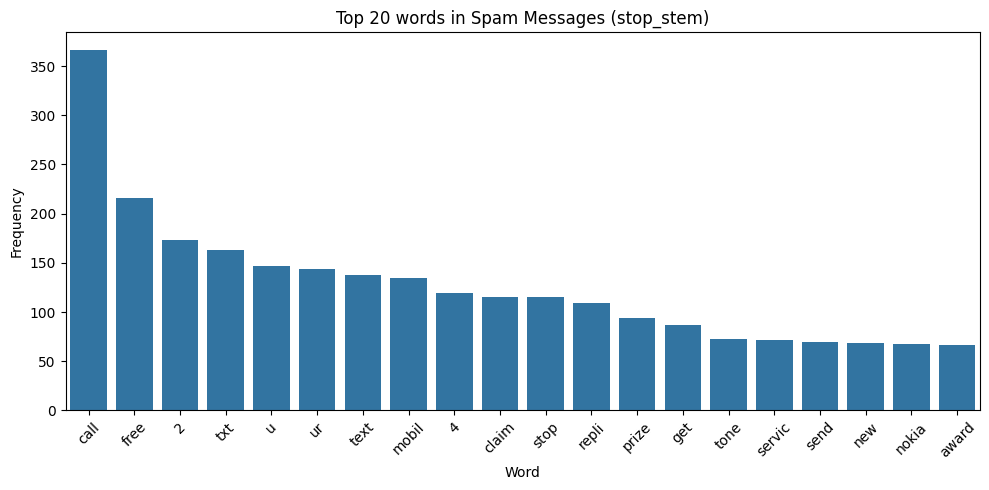

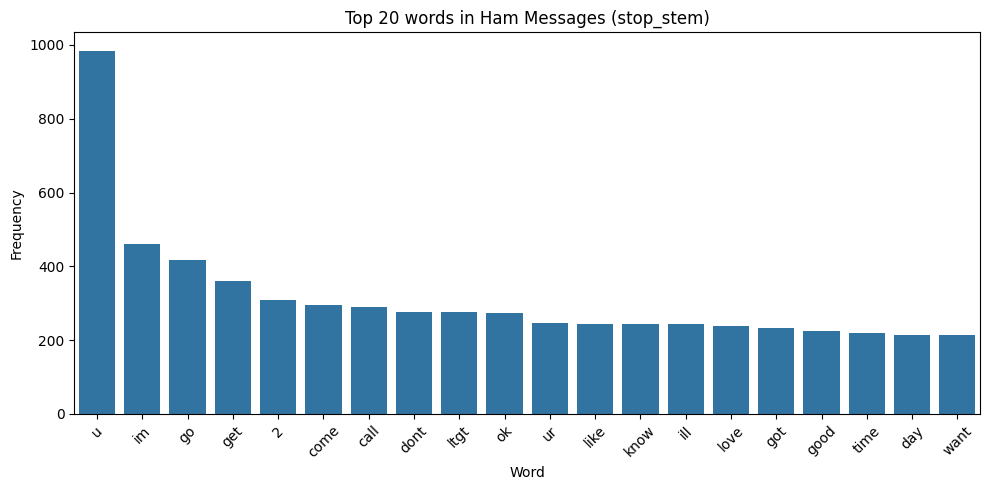

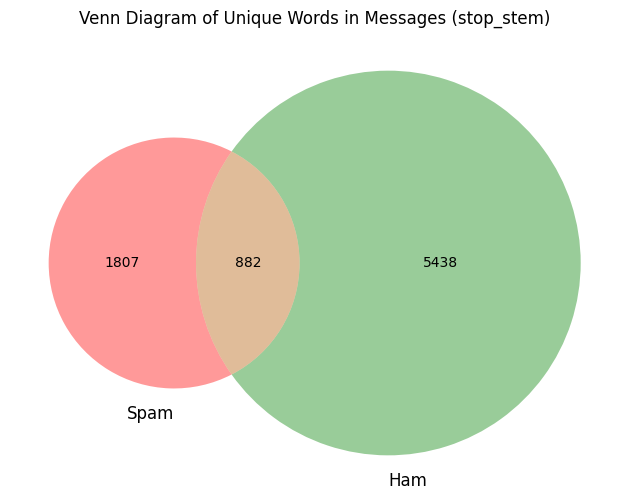

In [5]:
for variant in VARIANTS:
    plot_message_lengths(df, column=variant, label_column='label', title=variant, save_path=f'data/eda/{variant}/message_lengths.png')
    plot_top_words_by_class(df, column=variant, label_value='spam', top_n=20, title=f'Top 20 words in Spam Messages ({variant})',save_path=f'data/eda/{variant}/top_spam.png')
    plot_top_words_by_class(df, column=variant, label_value='ham', top_n=20, title=f'Top 20 words in Ham Messages ({variant})', save_path=f'data/eda/{variant}/top_ham.png')
    plot_venn_words(df, column=variant, title=f'Venn Diagram of Unique Words in Messages ({variant})', save_path=f'data/eda/{variant}/venn.png')


## Train/Evaluate Models

In [6]:
RANDOM_STATE = 202505

### Baseline

In [7]:
for variant in VARIANTS:
    print(variant)
    _, _, baseline_stats = run_baseline_model(df, column=variant, label_column='label', test_size=0.2, random_state=RANDOM_STATE)
    write_stats_to_csv(baseline_stats, f'data/stats.csv')

print('ham_as_spam')
for missed in baseline_stats['misclassified']['ham_as_spam'][:10]:
    print(missed)

print('spam_as_ham')
for missed in baseline_stats['misclassified']['spam_as_ham'][:10]:
    print(missed)



raw
Training Time: 0.0189 seconds
Classification Report:
              precision    recall  f1-score   support

         Ham       0.96      1.00      0.98       979
        Spam       0.99      0.69      0.81       136

    accuracy                           0.96      1115
   macro avg       0.97      0.85      0.90      1115
weighted avg       0.96      0.96      0.96      1115

Confusion Matrix:
[[978   1]
 [ 42  94]]
Saved confusion matrix to data/baseline/baseline_raw_cf.png
Saved ROC curve to data/baseline/baseline_raw_roc.png
stop
Training Time: 0.0121 seconds
Classification Report:
              precision    recall  f1-score   support

         Ham       0.95      1.00      0.97       979
        Spam       0.99      0.63      0.77       136

    accuracy                           0.95      1115
   macro avg       0.97      0.82      0.87      1115
weighted avg       0.96      0.95      0.95      1115

Confusion Matrix:
[[978   1]
 [ 50  86]]
Saved confusion matrix to data/base

In [8]:
for variant in VARIANTS:
    print(variant)
    _, _, bert_stats = run_bert_model(df, column=variant, label_column='label', test_size=0.2, random_state=RANDOM_STATE)
    write_stats_to_csv(bert_stats, f'data/stats.csv')

    print('ham_as_spam')
    for missed in bert_stats['misclassified']['ham_as_spam'][:10]:
        print(missed)

    print('spam_as_ham')
    for missed in bert_stats['misclassified']['spam_as_ham'][:10]:
        print(missed)

raw


Map: 100%|██████████| 1115/1115 [00:00<00:00, 28331.99 examples/s]
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Epoch 1: avg training loss = 0.0757
Epoch 2: avg training loss = 0.0344
Epoch 3: avg training loss = 0.0310
Epoch 4: avg training loss = 0.0282
Epoch 5: avg training loss = 0.0226
Epoch 6: avg training loss = 0.0402
Epoch 7: avg training loss = 0.0445
Early stopping triggered at epoch 7
Training Time: 176.4524 seconds
Classification Report:
              precision    recall  f1-score   support

         Ham       0.99      1.00      0.99       979
        Spam       0.98      0.90      0.93       136

    accuracy                           0.98      1115
   macro avg       0.98      0.95      0.96      1115
weighted avg       0.98      0.98      0.98      1115

Saved confusion matrix to data/bert/bert_raw_cf.png
Saved ROC curve to data/bert/bert_raw_roc.png
ham_as_spam
yun ahthe ubi one say if ü wan call by tomorrowcall 67441233 look for ireneere only got bus822656166382 ubi cresubi tech park6ph for 1st 5wkg daysèn
ok can be later showing around 8830 if you want cld have drink before w

Map: 100%|██████████| 1115/1115 [00:00<00:00, 33461.52 examples/s]
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Epoch 1: avg training loss = 0.0925
Epoch 2: avg training loss = 0.0314
Epoch 3: avg training loss = 0.0166
Epoch 4: avg training loss = 0.0244
Epoch 5: avg training loss = 0.0345
Early stopping triggered at epoch 5
Training Time: 92.8208 seconds
Classification Report:
              precision    recall  f1-score   support

         Ham       1.00      0.92      0.96       979
        Spam       0.64      0.98      0.77       136

    accuracy                           0.93      1115
   macro avg       0.82      0.95      0.86      1115
weighted avg       0.95      0.93      0.94      1115

Saved confusion matrix to data/bert/bert_stop_cf.png
Saved ROC curve to data/bert/bert_stop_roc.png
ham_as_spam
chinatown got porridge claypot rice yam cake fishhead beehoon either eat cheap den go cafe n tok go nydc somethin
hi u decide wot 2 get 4 bday ill prob jus get voucher frm virgin sumfing
hey u fancy meetin 4 cha hav lil beverage txt ring meet l8r quite tired got 3 vpist love pete x x x
have

Map: 100%|██████████| 1115/1115 [00:00<00:00, 34556.35 examples/s]
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Epoch 1: avg training loss = 0.0879
Epoch 2: avg training loss = 0.1456
Epoch 3: avg training loss = 0.0695
Epoch 4: avg training loss = 0.0761
Epoch 5: avg training loss = 0.1216
Early stopping triggered at epoch 5
Training Time: 87.4136 seconds
Classification Report:
              precision    recall  f1-score   support

         Ham       0.98      1.00      0.99       979
        Spam       0.97      0.85      0.91       136

    accuracy                           0.98      1115
   macro avg       0.98      0.92      0.95      1115
weighted avg       0.98      0.98      0.98      1115

Saved confusion matrix to data/bert/bert_stop_lemma_cf.png
Saved ROC curve to data/bert/bert_stop_lemma_roc.png
ham_as_spam
yeh def up4 something satjust got payed2day havbeen given a50 pay rise 4my work havebeen made preschoolcoordinator 2i feelingood luv
yun ahthe ubi one say ü wan call tomorrowcall 67441233 look ireneere got bus822656166382 ubi cresubi tech park6ph 1st 5wkg daysèn
luton 0125698789

Map: 100%|██████████| 1115/1115 [00:00<00:00, 29863.66 examples/s]
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Epoch 1: avg training loss = 0.1002
Epoch 2: avg training loss = 0.0509
Epoch 3: avg training loss = 0.0264
Epoch 4: avg training loss = 0.0181
Epoch 5: avg training loss = 0.0169
Epoch 6: avg training loss = 0.0060
Epoch 7: avg training loss = 0.0287
Epoch 8: avg training loss = 0.0820
Early stopping triggered at epoch 8
Training Time: 149.0175 seconds
Classification Report:
              precision    recall  f1-score   support

         Ham       0.99      1.00      0.99       979
        Spam       0.97      0.93      0.95       136

    accuracy                           0.99      1115
   macro avg       0.98      0.96      0.97      1115
weighted avg       0.99      0.99      0.99      1115

Saved confusion matrix to data/bert/bert_stop_stem_cf.png
Saved ROC curve to data/bert/bert_stop_stem_roc.png
ham_as_spam
account refil success inr ltdecimalgt keralacircl prepaid account balanc rs ltdecimalgt transact id kr ltgt
hi mobil ltgt ad contact list wwwfullonsmscom great place send f